In [2]:
"""
Programmer: Chris Tralie
Purpose: To use the POT library (https://github.com/rflamary/POT)
to compute the Entropic regularized Wasserstein distance 
between points on a 2D grid
"""
import numpy as np
import matplotlib.pyplot as plt
import ot
import torch
from torch import nn

# Sinkhorn

In [4]:
## Step 1: Setup problem
pix = np.linspace(-1, 1, 17)
# Setup grid
X, Y = np.meshgrid(pix, pix)
# Compute pariwise distances between points on 2D grid so we know
# how to score the Wasserstein distance
coords = np.array([X.flatten(), Y.flatten()]).T
coordsSqr = np.sum(coords**2, 1)
M = coordsSqr[:, None] + coordsSqr[None, :] - 2*coords.dot(coords.T)
M[M < 0] = 0
M = np.sqrt(M)

In [25]:
n = 3

## Step 1: Setup problem
pix = np.linspace(-1, 1, n)
# Setup grid
X, Y = np.meshgrid(pix, pix)
# Compute pariwise distances between points on 2D grid so we know
# how to score the Wasserstein distance
coords = np.array([X.flatten(), Y.flatten()]).T
coordsSqr = np.sum(coords**2, 1)
M = coordsSqr[:, None] + coordsSqr[None, :] - 2*coords.dot(coords.T)
M[M < 0] = 0
M = np.sqrt(M)

A = np.random.rand(n,n)
B = np.random.rand(n,n)

wass = ot.sinkhorn2(A.flatten(), B.flatten(), M, 1.0)
print(wass)

wass = ot.sinkhorn2(A.flatten(), A.flatten(), M, 1.0)
print(wass)

5.608810432446129
4.550246483701667


# GROMOV-WASSERSTIN

In [9]:
# Way more metricy

n = 17

A = np.random.rand(n,n)
B = np.random.rand(n,n)

wass = ot.gromov_wasserstein2(A, B)
print(wass)

wass = ot.gromov_wasserstein2(B, A)
print(wass)

wass = ot.gromov_wasserstein2(A*5, B)
print(wass)

wass = ot.gromov_wasserstein2(A, A)
print(wass)

0.11026422418676916
0.11026422418676837
5.8449008362760395
-6.718584022458174e-15


# Earth Mover Distance

In [11]:
torch.manual_seed(1)
sigma = 0.1
n_dims = 2
n_features = 2


def get_data(n_samples):
    c = torch.rand(size=(n_samples, 1))
    angle = c * 2 * np.pi
    x = torch.cat((torch.cos(angle), torch.sin(angle)), 1)
    x += torch.randn(n_samples, 2) * sigma
    return x

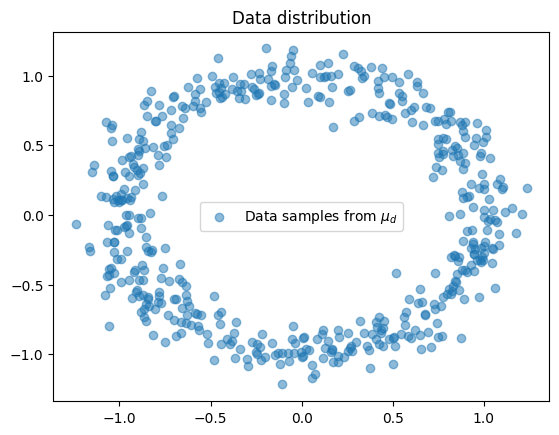

In [13]:
# plot the distributions
x = get_data(500)
plt.figure(1)
plt.scatter(x[:, 0], x[:, 1], label='Data samples from $\mu_d$', alpha=0.5)
plt.title('Data distribution')
plt.legend()

In [15]:
# define the MLP model
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(n_features, 200)
        self.fc2 = nn.Linear(200, 500)
        self.fc3 = nn.Linear(500, n_dims)
        self.relu = torch.nn.ReLU()  # instead of Heaviside step fn

    def forward(self, x):
        output = self.fc1(x)
        output = self.relu(output)  # instead of Heaviside step fn
        output = self.fc2(output)
        output = self.relu(output)
        output = self.fc3(output)
        return output

In [16]:
G = Generator()
optimizer = torch.optim.RMSprop(G.parameters(), lr=0.00019, eps=1e-5)

# number of iteration and size of the batches
n_iter = 200  # set to 200 for doc build but 1000 is better ;)
size_batch = 500

# generate statis samples to see their trajectory along training
n_visu = 100
xnvisu = torch.randn(n_visu, n_features)
xvisu = torch.zeros(n_iter, n_visu, n_dims)

ab = torch.ones(size_batch) / size_batch
losses = []


for i in range(n_iter):

    # generate noise samples
    xn = torch.randn(size_batch, n_features)

    # generate data samples
    xd = get_data(size_batch)

    # generate sample along iterations
    xvisu[i, :, :] = G(xnvisu).detach()

    # generate smaples and compte distance matrix
    xg = G(xn)
    M = ot.dist(xg, xd)

    loss = ot.emd2(ab, ab, M)
    losses.append(float(loss.detach()))

    if i % 10 == 0:
        print("Iter: {:3d}, loss={}".format(i, losses[-1]))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    del M

plt.figure(2)
plt.semilogy(losses)
plt.grid()
plt.title('Wasserstein distance')
plt.xlabel("Iterations")

Iter:   0, loss=0.9129706621170044
Iter:  10, loss=0.109415702521801
Iter:  20, loss=0.05602818354964256
Iter:  30, loss=0.04204617813229561
Iter:  40, loss=0.050672952085733414


KeyboardInterrupt: 

In [63]:
# Define dimensionof square matrix
n = 17

# Generate two embedding matricies
A = np.random.rand(n,n)
B = np.random.rand(n,n)

# Weight pixels by intensity
w_a = A.flatten() / A.sum()
w_b = B.flatten() / B.sum()

# Determine the distance matrix for moving between pixels
pix = np.linspace(-1, 1, n)
# Setup grid
X, Y = np.meshgrid(pix, pix)
# Compute pariwise distances between points on 2D grid so we know
# how to score the Wasserstein distance
coords = np.array([X.flatten(), Y.flatten()]).T
coordsSqr = np.sum(coords**2, 1)
M = coordsSqr[:, None] + coordsSqr[None, :] - 2*coords.dot(coords.T)
M[M < 0] = 0
M = np.sqrt(M)

dist = ot.emd2(w_a, w_b, M)

print(dist)

0.08095810519669724


In [66]:
M.shape

(289, 289)